In [2]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST


mnist = FashionMNIST(root='data',train=True,download=True,transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [3]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [4]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


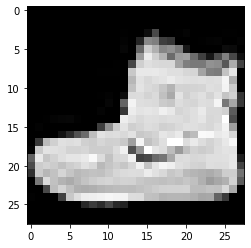

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [6]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([1, 5, 9, 2, 1, 9, 9, 3, 7, 4, 2, 4, 7, 3, 2, 4, 9, 3, 7, 8, 8, 9, 7, 5,
        0, 1, 3, 3, 1, 3, 5, 1, 7, 4, 2, 0, 5, 2, 2, 6, 1, 6, 0, 3, 8, 0, 9, 4,
        3, 0, 8, 0, 9, 2, 9, 2, 8, 7, 3, 7, 0, 0, 8, 4, 9, 5, 0, 6, 7, 8, 0, 3,
        3, 7, 2, 6, 1, 6, 7, 3, 9, 6, 3, 0, 1, 4, 1, 9, 7, 0, 1, 1, 5, 3, 0, 7,
        3, 1, 9, 4])


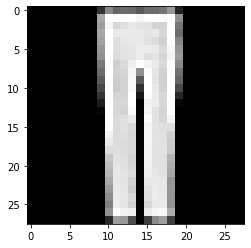

In [7]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [8]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cpu')

In [10]:
image_size = 784
hidden_size = 256

In [11]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [12]:
D.to(device);

In [13]:
latent_size = 64

In [14]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [15]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

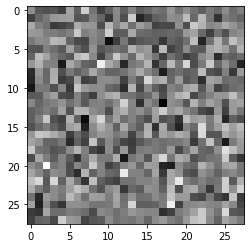

In [16]:
plt.imshow(gen_imgs[0], cmap='gray');

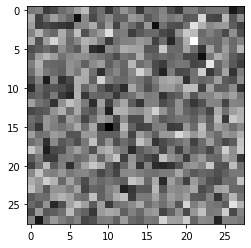

In [17]:
plt.imshow(gen_imgs[1], cmap='gray');

In [18]:
G.to(device);

In [19]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [20]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [21]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [22]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [23]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

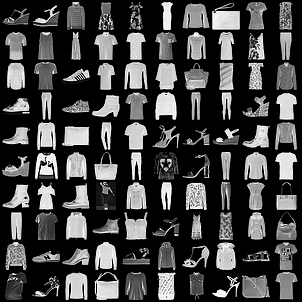

In [24]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


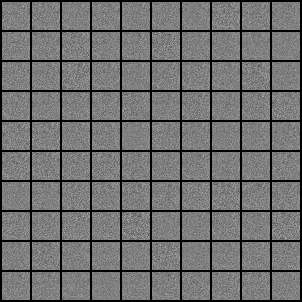

In [25]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

We are now ready to train the model. In each epoch, we train the discriminator first, and then the generator. The training might take a while if you're not using a GPU.

In [26]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0621, g_loss: 4.0505, D(x): 0.99, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.1348, g_loss: 6.4627, D(x): 0.96, D(G(z)): 0.04
Epoch [0/300], Step [600/600], d_loss: 0.0496, g_loss: 4.3081, D(x): 0.99, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0132, g_loss: 5.0117, D(x): 1.00, D(G(z)): 0.01
Epoch [1/300], Step [400/600], d_loss: 0.0816, g_loss: 4.8341, D(x): 0.97, D(G(z)): 0.01
Epoch [1/300], Step [600/600], d_loss: 0.0098, g_loss: 6.1537, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0344, g_loss: 5.8922, D(x): 0.99, D(G(z)): 0.02
Epoch [2/300], Step [400/600], d_loss: 0.1831, g_loss: 8.0379, D(x): 0.96, D(G(z)): 0.02
Epoch [2/300], Step [600/600], d_loss: 0.0241, g_loss: 6.2937, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.1228, g_loss: 5.8667, D(x): 0.95, D(G(z)): 0.02
Epoch [3/300], Step [400/6

Epoch [27/300], Step [600/600], d_loss: 0.6090, g_loss: 2.7053, D(x): 0.87, D(G(z)): 0.21
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.3417, g_loss: 3.5064, D(x): 0.88, D(G(z)): 0.10
Epoch [28/300], Step [400/600], d_loss: 0.4602, g_loss: 2.9737, D(x): 0.87, D(G(z)): 0.14
Epoch [28/300], Step [600/600], d_loss: 0.4266, g_loss: 3.0288, D(x): 0.84, D(G(z)): 0.11
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.3270, g_loss: 3.7399, D(x): 0.93, D(G(z)): 0.14
Epoch [29/300], Step [400/600], d_loss: 0.3925, g_loss: 3.1973, D(x): 0.86, D(G(z)): 0.11
Epoch [29/300], Step [600/600], d_loss: 0.3081, g_loss: 3.7702, D(x): 0.92, D(G(z)): 0.13
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.5418, g_loss: 2.2717, D(x): 0.87, D(G(z)): 0.22
Epoch [30/300], Step [400/600], d_loss: 0.3275, g_loss: 4.1744, D(x): 0.87, D(G(z)): 0.05
Epoch [30/300], Step [600/600], d_loss: 0.5340, g_loss: 2.3150, D(x): 0.94, D(G(z)): 0.30
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.8143, g_loss: 3.1203, D(x): 0.68, D(G(z)): 0.11
Epoch [55/300], Step [600/600], d_loss: 0.6580, g_loss: 2.1055, D(x): 0.81, D(G(z)): 0.26
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.6906, g_loss: 2.7219, D(x): 0.78, D(G(z)): 0.21
Epoch [56/300], Step [400/600], d_loss: 0.7522, g_loss: 2.2693, D(x): 0.80, D(G(z)): 0.26
Epoch [56/300], Step [600/600], d_loss: 0.5654, g_loss: 2.9086, D(x): 0.78, D(G(z)): 0.13
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.5943, g_loss: 2.6799, D(x): 0.74, D(G(z)): 0.12
Epoch [57/300], Step [400/600], d_loss: 0.5752, g_loss: 2.6506, D(x): 0.84, D(G(z)): 0.21
Epoch [57/300], Step [600/600], d_loss: 0.8588, g_loss: 2.3401, D(x): 0.74, D(G(z)): 0.26
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.7422, g_loss: 2.6625, D(x): 0.76, D(G(z)): 0.20
Epoch [58/300], Step [400/600], d_loss: 0.7592, g_loss: 2.0167, D(x): 0.78, D(G(z)): 0.25
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 0.6995, g_loss: 2.0376, D(x): 0.73, D(G(z)): 0.19
Epoch [83/300], Step [400/600], d_loss: 1.0916, g_loss: 2.3873, D(x): 0.66, D(G(z)): 0.23
Epoch [83/300], Step [600/600], d_loss: 1.0839, g_loss: 1.3750, D(x): 0.83, D(G(z)): 0.46
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.7349, g_loss: 2.6516, D(x): 0.77, D(G(z)): 0.22
Epoch [84/300], Step [400/600], d_loss: 1.0596, g_loss: 1.9557, D(x): 0.77, D(G(z)): 0.39
Epoch [84/300], Step [600/600], d_loss: 1.2132, g_loss: 1.7803, D(x): 0.70, D(G(z)): 0.34
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.8054, g_loss: 2.1155, D(x): 0.79, D(G(z)): 0.29
Epoch [85/300], Step [400/600], d_loss: 0.8214, g_loss: 1.9822, D(x): 0.77, D(G(z)): 0.26
Epoch [85/300], Step [600/600], d_loss: 0.8305, g_loss: 1.6477, D(x): 0.79, D(G(z)): 0.33
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.7157, g_loss: 1.5819, D(x): 0.79, D(G(z)): 0.27
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 0.9714, g_loss: 1.7529, D(x): 0.77, D(G(z)): 0.38
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.9280, g_loss: 1.8218, D(x): 0.69, D(G(z)): 0.25
Epoch [111/300], Step [400/600], d_loss: 1.0691, g_loss: 1.5136, D(x): 0.69, D(G(z)): 0.32
Epoch [111/300], Step [600/600], d_loss: 1.0579, g_loss: 1.7226, D(x): 0.66, D(G(z)): 0.34
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.8432, g_loss: 1.3673, D(x): 0.69, D(G(z)): 0.30
Epoch [112/300], Step [400/600], d_loss: 0.9043, g_loss: 1.6179, D(x): 0.68, D(G(z)): 0.27
Epoch [112/300], Step [600/600], d_loss: 1.0565, g_loss: 1.6835, D(x): 0.67, D(G(z)): 0.29
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.8839, g_loss: 1.9042, D(x): 0.67, D(G(z)): 0.26
Epoch [113/300], Step [400/600], d_loss: 0.9650, g_loss: 1.4512, D(x): 0.70, D(G(z)): 0.32
Epoch [113/300], Step [600/600], d_loss: 0.8803, g_loss: 1.5698, D(x): 0.68, D(G(z)): 0.29
Saving

Epoch [138/300], Step [200/600], d_loss: 0.9690, g_loss: 1.6596, D(x): 0.77, D(G(z)): 0.38
Epoch [138/300], Step [400/600], d_loss: 0.9395, g_loss: 1.8198, D(x): 0.67, D(G(z)): 0.27
Epoch [138/300], Step [600/600], d_loss: 1.0901, g_loss: 1.6943, D(x): 0.69, D(G(z)): 0.39
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 1.3297, g_loss: 1.4146, D(x): 0.66, D(G(z)): 0.43
Epoch [139/300], Step [400/600], d_loss: 0.6168, g_loss: 1.7503, D(x): 0.80, D(G(z)): 0.23
Epoch [139/300], Step [600/600], d_loss: 0.9310, g_loss: 1.7951, D(x): 0.68, D(G(z)): 0.30
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.8195, g_loss: 1.8110, D(x): 0.70, D(G(z)): 0.23
Epoch [140/300], Step [400/600], d_loss: 0.9410, g_loss: 1.4359, D(x): 0.66, D(G(z)): 0.30
Epoch [140/300], Step [600/600], d_loss: 1.1646, g_loss: 1.4899, D(x): 0.64, D(G(z)): 0.38
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 1.0321, g_loss: 1.1011, D(x): 0.66, D(G(z)): 0.32
Epoch 

Epoch [165/300], Step [400/600], d_loss: 0.9961, g_loss: 1.3227, D(x): 0.63, D(G(z)): 0.30
Epoch [165/300], Step [600/600], d_loss: 1.0944, g_loss: 1.2889, D(x): 0.69, D(G(z)): 0.41
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 0.9497, g_loss: 1.2575, D(x): 0.67, D(G(z)): 0.30
Epoch [166/300], Step [400/600], d_loss: 1.0462, g_loss: 1.3832, D(x): 0.71, D(G(z)): 0.39
Epoch [166/300], Step [600/600], d_loss: 0.9406, g_loss: 1.5196, D(x): 0.63, D(G(z)): 0.29
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 0.9843, g_loss: 1.6144, D(x): 0.62, D(G(z)): 0.30
Epoch [167/300], Step [400/600], d_loss: 1.1430, g_loss: 1.2464, D(x): 0.70, D(G(z)): 0.45
Epoch [167/300], Step [600/600], d_loss: 0.9766, g_loss: 1.3224, D(x): 0.70, D(G(z)): 0.34
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 1.0318, g_loss: 1.4252, D(x): 0.61, D(G(z)): 0.29
Epoch [168/300], Step [400/600], d_loss: 1.0563, g_loss: 1.3201, D(x): 0.67, D(G(z)): 0.37
Epoch 

Epoch [192/300], Step [600/600], d_loss: 0.9446, g_loss: 1.4553, D(x): 0.69, D(G(z)): 0.35
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.7845, g_loss: 1.4842, D(x): 0.76, D(G(z)): 0.32
Epoch [193/300], Step [400/600], d_loss: 1.0252, g_loss: 1.4569, D(x): 0.69, D(G(z)): 0.37
Epoch [193/300], Step [600/600], d_loss: 1.0619, g_loss: 1.5078, D(x): 0.63, D(G(z)): 0.32
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 0.9836, g_loss: 1.5756, D(x): 0.63, D(G(z)): 0.31
Epoch [194/300], Step [400/600], d_loss: 1.1766, g_loss: 1.3244, D(x): 0.58, D(G(z)): 0.33
Epoch [194/300], Step [600/600], d_loss: 1.0659, g_loss: 1.2274, D(x): 0.65, D(G(z)): 0.34
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 1.0021, g_loss: 1.3223, D(x): 0.64, D(G(z)): 0.33
Epoch [195/300], Step [400/600], d_loss: 0.9819, g_loss: 1.3693, D(x): 0.65, D(G(z)): 0.34
Epoch [195/300], Step [600/600], d_loss: 0.9370, g_loss: 1.1850, D(x): 0.69, D(G(z)): 0.36
Saving

Epoch [220/300], Step [200/600], d_loss: 1.4277, g_loss: 1.1478, D(x): 0.56, D(G(z)): 0.43
Epoch [220/300], Step [400/600], d_loss: 1.0745, g_loss: 1.1923, D(x): 0.65, D(G(z)): 0.38
Epoch [220/300], Step [600/600], d_loss: 0.9908, g_loss: 1.2137, D(x): 0.61, D(G(z)): 0.29
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.9147, g_loss: 1.4880, D(x): 0.64, D(G(z)): 0.26
Epoch [221/300], Step [400/600], d_loss: 1.0394, g_loss: 1.1167, D(x): 0.72, D(G(z)): 0.41
Epoch [221/300], Step [600/600], d_loss: 1.2549, g_loss: 1.0678, D(x): 0.60, D(G(z)): 0.42
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 1.1146, g_loss: 1.2163, D(x): 0.63, D(G(z)): 0.36
Epoch [222/300], Step [400/600], d_loss: 0.9963, g_loss: 1.2850, D(x): 0.72, D(G(z)): 0.38
Epoch [222/300], Step [600/600], d_loss: 1.0552, g_loss: 1.4746, D(x): 0.65, D(G(z)): 0.33
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 1.0047, g_loss: 1.3569, D(x): 0.62, D(G(z)): 0.29
Epoch 

Epoch [247/300], Step [400/600], d_loss: 1.0267, g_loss: 1.3511, D(x): 0.60, D(G(z)): 0.30
Epoch [247/300], Step [600/600], d_loss: 1.0256, g_loss: 1.3860, D(x): 0.61, D(G(z)): 0.31
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 1.1380, g_loss: 1.2362, D(x): 0.58, D(G(z)): 0.33
Epoch [248/300], Step [400/600], d_loss: 1.2180, g_loss: 1.2304, D(x): 0.56, D(G(z)): 0.37
Epoch [248/300], Step [600/600], d_loss: 0.9674, g_loss: 1.4960, D(x): 0.61, D(G(z)): 0.26
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 1.1288, g_loss: 1.2848, D(x): 0.61, D(G(z)): 0.36
Epoch [249/300], Step [400/600], d_loss: 1.3744, g_loss: 1.1209, D(x): 0.57, D(G(z)): 0.42
Epoch [249/300], Step [600/600], d_loss: 1.3619, g_loss: 1.0008, D(x): 0.52, D(G(z)): 0.35
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.8904, g_loss: 1.3892, D(x): 0.74, D(G(z)): 0.36
Epoch [250/300], Step [400/600], d_loss: 0.9648, g_loss: 1.0798, D(x): 0.68, D(G(z)): 0.35
Epoch 

Epoch [274/300], Step [600/600], d_loss: 1.0600, g_loss: 1.4942, D(x): 0.62, D(G(z)): 0.33
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 1.1855, g_loss: 1.3563, D(x): 0.61, D(G(z)): 0.38
Epoch [275/300], Step [400/600], d_loss: 1.0840, g_loss: 1.4176, D(x): 0.58, D(G(z)): 0.28
Epoch [275/300], Step [600/600], d_loss: 0.9951, g_loss: 1.3532, D(x): 0.67, D(G(z)): 0.34
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.8740, g_loss: 1.4924, D(x): 0.68, D(G(z)): 0.30
Epoch [276/300], Step [400/600], d_loss: 1.2413, g_loss: 1.1462, D(x): 0.59, D(G(z)): 0.41
Epoch [276/300], Step [600/600], d_loss: 1.3660, g_loss: 1.1248, D(x): 0.56, D(G(z)): 0.41
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.8359, g_loss: 1.6379, D(x): 0.69, D(G(z)): 0.31
Epoch [277/300], Step [400/600], d_loss: 1.2790, g_loss: 1.1317, D(x): 0.54, D(G(z)): 0.35
Epoch [277/300], Step [600/600], d_loss: 0.9747, g_loss: 1.4227, D(x): 0.67, D(G(z)): 0.34
Saving

Now that we have trained the models, we can save checkpoints.

In [27]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

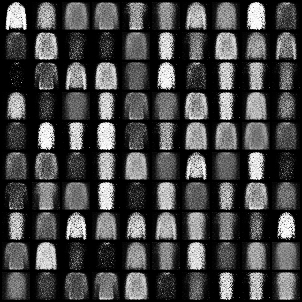

In [28]:
Image('./samples/fake_images-0010.png')

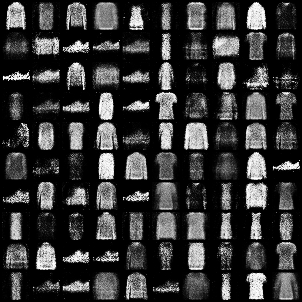

In [29]:
Image('./samples/fake_images-0050.png')

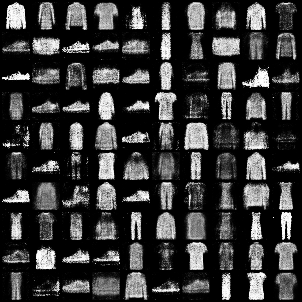

In [30]:
Image('./samples/fake_images-0100.png')

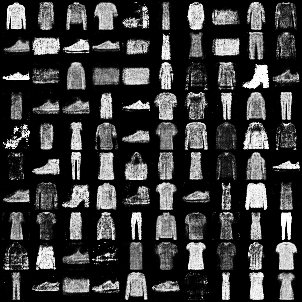

In [31]:
Image('./samples/fake_images-0300.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [32]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

D:\mini\gans_training.avi

Text(0.5, 1.0, 'Losses')

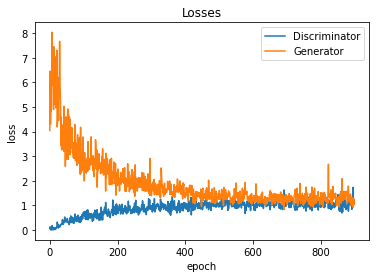

In [33]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

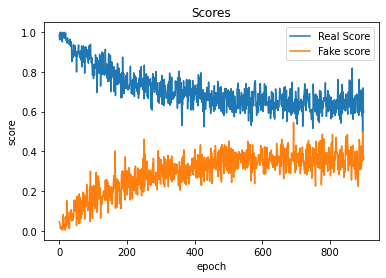

In [34]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores')